#Student Name:Ganapathy
#Student ID:18202799

In [1]:
# Imports needed for the script

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Loading the data
blackfridaydata = pd.read_csv('C:\\Users\\sga01\\Documents\\GitHub\\Week7\\BlackFriday\\BlackFridayV1.csv')

print(blackfridaydata)
# Store our test User IDs for easy access
userId = blackfridaydata['User_ID']

#https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset

# Showing overview of the Blackfriday dataset
print(blackfridaydata.head(3))

# Feature that tells whether a user belongs to City
print(type(blackfridaydata))
blackfridaydata['City_Category'] = blackfridaydata['City_Category'].map({'A': 1, 'B': 0}).astype(int)
#blackfridaydata['City_Category'] = blackfridaydata['City_Category'].apply(lambda x: 0 if type(x) == float else 1)
blackfridaydata['Age'] = blackfridaydata['Age'].map({'0-17': 0, '18-25': 1,'26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}).astype(int)
blackfridaydata['Gender'] = blackfridaydata['Gender'].map({'M': 1, 'F': 0})
blackfridaydata['Stay_In_Current_City_Years'] = blackfridaydata['Stay_In_Current_City_Years'].map({'0': 0, '1': 1, '2': 2, '3': 3, '4+': 4}).astype(int)
#blackfridaydata['Product_ID'] = blackfridaydata['Product_ID'].strip('P').astype(int)

# Remove all NULLS in the Age column
blackfridaydata['Product_Category_2'] = blackfridaydata['Product_Category_2'].fillna(0)
blackfridaydata['Product_Category_3'] = blackfridaydata['Product_Category_3'].fillna(0)
print(blackfridaydata['Product_ID'])


        User_ID Product_ID Gender    Age  Occupation City_Category  \
0       1000001  P00069042      F   0-17          10             A   
1       1000001  P00248942      F   0-17          10             A   
2       1000001  P00087842      F   0-17          10             A   
3       1000001  P00085442      F   0-17          10             A   
4       1000003  P00193542      M  26-35          15             A   
5       1000004  P00184942      M  46-50           7             B   
6       1000004  P00346142      M  46-50           7             B   
7       1000004   P0097242      M  46-50           7             B   
8       1000005  P00274942      M  26-35          20             A   
9       1000005  P00251242      M  26-35          20             A   
10      1000005  P00014542      M  26-35          20             A   
11      1000005  P00031342      M  26-35          20             A   
12      1000005  P00145042      M  26-35          20             A   
13      1000006  P00

0         P00069042
1         P00248942
2         P00087842
3         P00085442
4         P00193542
5         P00184942
6         P00346142
7          P0097242
8         P00274942
9         P00251242
10        P00014542
11        P00031342
12        P00145042
13        P00231342
14        P00190242
15         P0096642
16        P00058442
17        P00036842
18        P00085942
19        P00118742
20        P00297942
21        P00266842
22        P00058342
23        P00032442
24        P00105942
25        P00182642
26        P00186942
27        P00155442
28        P00221342
29        P00087242
            ...    
371101    P00319042
371102    P00209842
371103    P00255942
371104    P00103042
371105    P00005042
371106    P00219942
371107    P00041842
371108    P00113842
371109    P00124642
371110    P00051442
371111    P00085242
371112    P00117242
371113    P00093342
371114    P00111042
371115    P00345842
371116    P00194542
371117    P00175242
371118    P00101942
371119    P00109142


In [2]:

# Feature selection: remove variables no longer containing relevant information

drop_elements = ['User_ID', 'Product_ID', 'Purchase']
blackfridaydata = blackfridaydata.drop(drop_elements, axis = 1)
#print(blackfridaydata)
print(blackfridaydata.head(3))

   Gender  Age  Occupation  City_Category  Stay_In_Current_City_Years  \
0       0    0          10              1                           2   
1       0    0          10              1                           2   
2       0    0          10              1                           2   

   Marital_Status  Product_Category_1  Product_Category_2  Product_Category_3  
0               0                   3                 0.0                 0.0  
1               0                   1                 6.0                14.0  
2               0                  12                 0.0                 0.0  


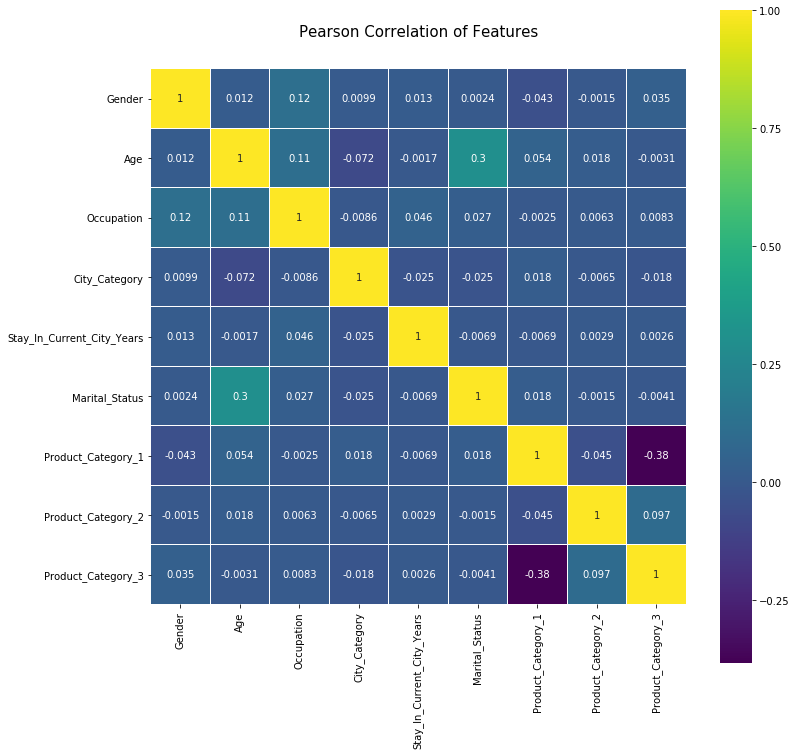

In [3]:

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(blackfridaydata.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)


In [4]:
blackfridaydata[['Age', 'Product_Category_1']].groupby(['Age'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Product category" is a binary class (0 to 6), these metrics grouped by the Title feature represent:
    # MEAN: Product rate
    # COUNT: total Products
    # SUM: Products sold

# blackfridaydata['Age'] = blackfridaydata['Age'].map({'0-17': 0, '18-25': 1,'26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}).astype(int)


Product_Category_1                
                  mean   count     sum
Age                                   
0             5.022864    7785   39103
1             5.086438   69495  353482
2             5.306473  161815  858667
3             5.451840   72747  396605
4             5.632404   27367  154142
5             5.737694   23404  134285
6             5.943414    8518   50626

In [5]:
blackfridaydata[['Gender', 'Product_Category_1']].groupby(['Gender'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Product Category is a binary feature, this metrics grouped by the Gender feature represent:
    # MEAN: Product rate
    # COUNT: total Products
    # SUM: products Sold
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Product_Category_1                 
                     mean   count      sum
Gender                                    
0                5.635634   91301   514539
1                5.261662  279830  1472371

In [6]:
# Table with 'Gender' distribution grouped by 'Age'
blackfridaydata[['Age', 'Gender']].groupby(['Age'], as_index=False).agg(['mean', 'count', 'sum'])

Gender                
         mean   count     sum
Age                          
0    0.619268    7785    4821
1    0.746946   69495   51909
2    0.765800  161815  123918
3    0.755688   72747   54974
4    0.726349   27367   19878
5    0.746795   23404   17478
6    0.804414    8518    6852

In [7]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

Let's use our Gender and Age features as an example and calculate how much each split will decrease the overall weighted Gini Impurity. First, we need to calculate the Gini Impurity of the starting node including all 371131 observations in our Black Friday dataset. Since only 147529 observations are married, the married probability is around 47,89% (147530/371132).

In [8]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(147529, 371131)
gini_impurity_starting_node

0.47899239091280993

We're now going to simulate both splits, calculate the impurity of resulting nodes and then obtain the weighted Gini Impurity after the split to measure how much each split has actually reduced impurity.

If we split by Gender, we'll have the two following nodes:

Node with men: 279830 observations with only 111426 married      

Node with women: 91301 observations with 36103 married

In [9]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(111426, 279830)
gini_impurity_men

0.47927016424398317

# Gini Impurity decrease if node splited for 'female' observations


In [10]:
gini_impurity_women = get_gini_impurity(36102, 91301)
gini_impurity_women

0.478124941055586

In [11]:
# Gini Impurity decrease if node splited by Sex
men_weight = 111426/279830
women_weight = 91301/36102
weighted_gini_impurity_Gender_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

Gender_gini_decrease = weighted_gini_impurity_Gender_split - gini_impurity_starting_node
Gender_gini_decrease

0.9210143274006053